In [1]:
import json
import multiprocessing
import cv2
import albumentations as A
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import pandas as pd
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime
import math
import random

from timm.utils.model_ema import ModelEmaV2

# Config

In [2]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2


class CFG:
    # ============== comp exp name =============
    comp_name = 'atmacup_18'  # comp名

    comp_dataset_path = '../raw/atmacup_18_dataset/'

    exp_name = 'atmacup_18_cnn_effnetb0'

    is_debug = False
    use_gray_scale = False

    model_in_chans = 9  # モデルの入力チャンネル数

    # ============== file path =============
    train_fold_dir = "../proc/baseline/folds"

    # ============== model cfg =============
    model_name = "tf_efficientnet_b0_ns"

    num_frames = 3  # model_in_chansの倍数
    norm_in_chans = 1 if use_gray_scale else 3

    use_torch_compile = False
    use_ema = True
    ema_decay = 0.995
    # ============== training cfg =============
    size = 224  # 224

    batch_size = 64  # 32

    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 20
    if is_debug:
        epochs = 2

    # adamW warmupあり
    warmup_factor = 10
    lr = 1e-3
    if scheduler == 'GradualWarmupSchedulerV2':
        lr /= warmup_factor

    # ============== fold =============
    n_fold = 5
    use_holdout = False
    use_alldata = False
    train_folds = [0, 1, 2, 3, 4]

    skf_col = 'class'
    group_col = 'scene'
    fold_type = 'gkf'

    objective_cv = 'regression'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'minimize'  # 'maximize', 'minimize'
    metrics = 'calc_mae_atmacup'

    # ============== pred target =============
    target_size = 18
    target_col = ['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2',
                  'z_2', 'x_3', 'y_3', 'z_3', 'x_4', 'y_4', 'z_4', 'x_5', 'y_5', 'z_5']


    # ============== ほぼ固定 =============
    pretrained = True
    inf_weight = 'last'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 500
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    if exp_name is not None:
        print('set dataset path')

        outputs_path = f'../proc/baseline/outputs/{exp_name}/'

        submission_dir = outputs_path + 'submissions/'
        submission_path = submission_dir + f'submission_{exp_name}.csv'

        model_dir = outputs_path + \
            f'{comp_name}-models/'

        figures_dir = outputs_path + 'figures/'

        log_dir = outputs_path + 'logs/'
        log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        # A.RandomRotate90(p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        # A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        # A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        # A.CoarseDropout(max_holes=1, max_height=int(
        #     size * 0.3), max_width=int(size * 0.3), p=0.5),

        A.Normalize(
            mean=[0] * norm_in_chans*num_frames,
            std=[1] * norm_in_chans*num_frames, 
        ),
        ToTensorV2(),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * norm_in_chans*num_frames,
            std=[1] * norm_in_chans*num_frames,
        ),
        ToTensorV2(),
    ]

set dataset path


In [3]:
print("CUDA が利用可能か:", torch.cuda.is_available())
print("利用可能な CUDA デバイス数:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("現在の CUDA デバイス:", torch.cuda.get_device_name(0))

CUDA が利用可能か: True
利用可能な CUDA デバイス数: 1
現在の CUDA デバイス: NVIDIA GeForce RTX 3090


# make fold

In [4]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


def get_fold(train, cfg):
    if cfg.fold_type == 'kf':
        Fold = KFold(n_splits=cfg.n_fold,
                     shuffle=True, random_state=cfg.seed)
        kf = Fold.split(train, train[cfg.target_col])
    elif cfg.fold_type == 'skf':
        Fold = StratifiedKFold(n_splits=cfg.n_fold,
                               shuffle=True, random_state=cfg.seed)
        kf = Fold.split(train, train[cfg.skf_col])
    elif cfg.fold_type == 'gkf':
        Fold = GroupKFold(n_splits=cfg.n_fold)
        groups = train[cfg.group_col].values
        kf = Fold.split(train, train[cfg.group_col], groups)
    elif cfg.fold_type == 'sgkf':
        Fold = StratifiedGroupKFold(n_splits=cfg.n_fold,
                                    shuffle=True, random_state=cfg.seed)
        groups = train[cfg.group_col].values
        kf = Fold.split(train, train[cfg.skf_col], groups)
    # elif fold_type == 'mskf':
    #     Fold = MultilabelStratifiedKFold(
    #         n_splits=cfg.n_fold, shuffle=True, random_state=cfg.seed)
    #     kf = Fold.split(train, train[cfg.skf_col])

    for n, (train_index, val_index) in enumerate(kf):
        train.loc[val_index, 'fold'] = int(n)
    train['fold'] = train['fold'].astype(int)

    print(train.groupby('fold').size())

    return train

In [5]:
def make_train_folds():
    train_df = pd.read_csv(CFG.comp_dataset_path + 'train_features.csv')

    train_df['scene'] = train_df['ID'].str.split('_').str[0]

    print('group', CFG.group_col)
    print(f'train len: {len(train_df)}')

    train_df = get_fold(train_df, CFG)

    # print(train_df.groupby(['fold', CFG.target_col]).size())
    print(train_df['fold'].value_counts())

    os.makedirs(CFG.train_fold_dir, exist_ok=True)

    train_df.to_csv(CFG.train_fold_dir +
                    'train_folds.csv', index=False)

In [6]:
make_train_folds()

group scene
train len: 43371
fold
0    8675
1    8674
2    8674
3    8674
4    8674
dtype: int64
fold
0    8675
1    8674
2    8674
3    8674
4    8674
Name: count, dtype: int64


# setting

In [7]:
# 乱数固定
def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)

    if mode == 'train':
        make_dirs(cfg)

In [8]:
cfg_init(CFG)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# logger

In [10]:
# from common_utils.logger import init_logger, wandb_init, AverageMeter, timeSince
# from common_utils.settings import cfg_init

def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [11]:
Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------
2024年11月21日 11:14:51


# eval function

In [12]:
def get_score(y_true, y_pred):
    # return roc_auc_score(y_true, y_pred)
    eval_func = eval(CFG.metrics)
    return eval_func(y_true, y_pred)


def calc_mae_atmacup(y_true, y_pred):
    abs_diff = np.abs(y_true - y_pred)  # 各予測の差分の絶対値を計算して
    mae = np.mean(abs_diff.reshape(-1, ))  # 予測の差分の絶対値の平均を計算

    return mae

def get_result(result_df):

    # preds = result_df['preds'].values

    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]
    preds = result_df[pred_cols].values
    labels = result_df[CFG.target_col].values
    score = get_score(labels, preds)
    Logger.info(f'score: {score:<.4f}')

    return score

# image utils

In [13]:
def draw_traffic_light(image, id):
    path = f'./datasets/atmacup_18/traffic_lights/{id}.json'
    traffic_lights = json.load(open(path))

    traffic_class = ['green',
                     'straight', 'left', 'right', 'empty', 'other', 'yellow', 'red']
    class_to_idx = {
        cls: idx for idx, cls in enumerate(traffic_class)
    }

    for traffic_light in traffic_lights:
        bbox = traffic_light['bbox']
        x1, y1, x2, y2 = bbox
        # int
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        point1 = (x1, y1)
        point2 = (x2, y2)

        idx = class_to_idx[traffic_light['class']]
        color = 255 - int(255*(idx/len(traffic_class)))

        cv2.rectangle(image, point1, point2, color=color, thickness=1)

    return image


def read_image_for_cache(path):
    if CFG.use_gray_scale:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # image = cv2.resize(image, (CFG.size, CFG.size))

    # 効かない
    # image = draw_traffic_light(image, path.split('/')[-2])
    return (path, image)


def make_video_cache(paths):
    debug = []
    for idx in range(9):
        color = 255 - int(255*(idx/9))
        debug.append(color)
    print(debug)

    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        res = pool.imap_unordered(read_image_for_cache, paths)
        res = tqdm(res)
        res = list(res)

    return dict(res)

# dataset

In [14]:
from albumentations import ReplayCompose
from torch.utils.data import DataLoader, Dataset
import albumentations as A

def get_transforms(data, cfg):
    if data == 'train':
        # aug = A.Compose(cfg.train_aug_list)
        aug = A.ReplayCompose(cfg.train_aug_list)
    elif data == 'valid':
        # aug = A.Compose(cfg.valid_aug_list)
        aug = A.ReplayCompose(cfg.valid_aug_list)

    # print(aug)
    return aug


class CustomDataset(Dataset):
    def __init__(self, df, cfg, labels=None, transform=None):
        self.df = df
        self.cfg = cfg
        self.base_paths = df['base_path'].values
        # self.labels = df[self.cfg.target_col].values
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def read_image_multiframe(self, idx):
        base_path = self.base_paths[idx]

        images = []
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix

            image = self.cfg.video_cache[path]

            images.append(image)
        return images

    def __getitem__(self, idx):
        image = self.read_image_multiframe(idx)

        if self.transform:
            # image = self.transform(image=image)['image']
            replay = None
            images = []
            for img in image:
                if replay is None:
                    sample = self.transform(image=img)
                    replay = sample['replay']
                else:
                    sample = ReplayCompose.replay(replay, image=img)
                images.append(sample['image'])

            image = torch.concat(images, dim=0)

        if self.labels is None:
            return image

        if self.cfg.objective_cv == 'multiclass':
            label = torch.tensor(self.labels[idx]).long()
        else:
            label = torch.tensor(self.labels[idx]).float()

        return image, label

In [15]:
def plot_aug_video(train, cfg, plot_count=1):
    transform = CFG.train_aug_list
    transform = A.ReplayCompose(transform)

    dataset = CustomDataset(
        train, CFG, transform=transform)

    for i in range(plot_count):
        image = dataset.read_image_multiframe(i)

        if cfg.use_gray_scale:
            image = np.stack(image, axis=2)
        else:
            image = np.concatenate(image, axis=2)

        aug_image = dataset[i]
        # torch to numpy
        aug_image = aug_image.permute(1, 2, 0).numpy()*255

        for frame in range(image.shape[-1]):
            if frame % 3 != 0:
                continue

            fig, axes = plt.subplots(1, 2, figsize=(15, 6))

            if cfg.use_gray_scale:
                axes[0].imshow(image[..., frame], cmap="gray")
                axes[1].imshow(aug_image[..., frame], cmap="gray")
            else:
                axes[0].imshow(image[..., frame:frame+3].astype(int))
                axes[1].imshow(aug_image[..., frame:frame+3].astype(int))
            plt.savefig(cfg.figures_dir +
                        f'aug_{i}_frame{frame}.png')

# model

In [16]:
import timm

class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False, target_size=None, model_name=None):
        super().__init__()
        # self.cfg = cfg

        if model_name is None:
            model_name = cfg.model_name

        print(f'pretrained: {pretrained}')

        self.model = timm.create_model(
            model_name, pretrained=pretrained, num_classes=0,
            in_chans=cfg.model_in_chans)

        self.n_features = self.model.num_features

        self.target_size = cfg.target_size if target_size is None else target_size

        # nn.Dropout(0.5),
        self.fc = nn.Sequential(
            nn.Linear(self.n_features, self.target_size)
        )

    def feature(self, image):

        feature = self.model(image)
        return feature

    def forward(self, image):
        feature = self.feature(image)
        output = self.fc(feature)
        return output

# scheduler

In [17]:
import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    if cfg.scheduler == 'ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(
            optimizer, mode='min', factor=cfg.factor, patience=cfg.patience, verbose=True, eps=cfg.eps)
    elif cfg.scheduler == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(
            optimizer, T_max=cfg.epochs, eta_min=cfg.min_lr, last_epoch=-1)
    elif cfg.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer, T_0=cfg.T_0, T_mult=1, eta_min=cfg.min_lr, last_epoch=-1)
    elif cfg.scheduler == 'GradualWarmupSchedulerV2':
        scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, cfg.epochs, eta_min=1e-7)
        scheduler = GradualWarmupSchedulerV2(
            optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    elif isinstance(scheduler, GradualWarmupSchedulerV2):
        scheduler.step(epoch)

# train

In [18]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device,
             model_ema=None):
    """ 1epoch毎のtrain """

    model.train()
    scaler = GradScaler(enabled=CFG.use_amp)

    losses = AverageMeter()
    preds = []
    preds_labels = []
    start = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)

            if y_preds.size(1) == 1:
                y_preds = y_preds.view(-1)

            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()

        if model_ema is not None:
            model_ema.update(model)

        optimizer.zero_grad()
        global_step += 1

        if CFG.objective_cv == 'binary':
            preds.append(torch.sigmoid(y_preds).detach().to('cpu').numpy())
        elif CFG.objective_cv == 'multiclass':
            preds.append(y_preds.softmax(1).detach().to('cpu').numpy())
        elif CFG.objective_cv == 'regression':
            preds.append(y_preds.detach().to('cpu').numpy())

        preds_labels.append(labels.detach().to('cpu').numpy())

        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(epoch + 1, step, len(train_loader),
                          remain=timeSince(start, float(
                              step + 1) / len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
    predictions = np.concatenate(preds)
    labels = np.concatenate(preds_labels)
    return losses.avg, predictions, labels


def valid_fn(valid_loader, model, criterion, device):

    model.eval()
    losses = AverageMeter()
    preds = []
    start = time.time()

    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)

        if y_preds.size(1) == 1:
            y_preds = y_preds.view(-1)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # binary
        if CFG.objective_cv == 'binary':
            preds.append(torch.sigmoid(y_preds).to('cpu').numpy())
        elif CFG.objective_cv == 'multiclass':
            preds.append(y_preds.softmax(1).to('cpu').numpy())
        elif CFG.objective_cv == 'regression':
            preds.append(y_preds.to('cpu').numpy())

        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step + 1) / len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [19]:
def train_fold(folds, fold):

    Logger.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    if CFG.use_alldata:
        train_folds = folds.copy().reset_index(drop=True)
    else:
        train_folds = folds.loc[trn_idx].reset_index(drop=True)

    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    # train_folds = train_downsampling(train_folds)

    train_labels = train_folds[CFG.target_col].values
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = CustomDataset(
        train_folds, CFG, labels=train_labels, transform=get_transforms(data='train', cfg=CFG))
    valid_dataset = CustomDataset(
        valid_folds, CFG, labels=valid_labels, transform=get_transforms(data='valid', cfg=CFG))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                              )
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================

    model = CustomModel(CFG, pretrained=CFG.pretrained)
    model.to(device)

    if CFG.use_ema:
        model_ema = ModelEmaV2(model, decay=CFG.ema_decay)
    else:
        model_ema = None

    optimizer = AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    # ====================================================
    # loop
    # ====================================================
    if CFG.objective_cv == 'binary':
        criterion = nn.BCEWithLogitsLoss()
    elif CFG.objective_cv == 'multiclass':
        criterion = nn.CrossEntropyLoss()
    elif CFG.objective_cv == 'regression':
        criterion = nn.L1Loss()

    if CFG.metric_direction == 'minimize':
        best_score = np.inf
    elif CFG.metric_direction == 'maximize':
        best_score = -1

    best_loss = np.inf

    df_score = pd.DataFrame(columns=["train_loss", 'train_score', 'val_loss', 'val_score'])

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss, train_preds, train_labels_epoch = train_fn(fold, train_loader, model,
                                                             criterion, optimizer, epoch, scheduler, device, model_ema)
        train_score = get_score(train_labels_epoch, train_preds)

        # eval
        if model_ema is not None:
            avg_val_loss, valid_preds = valid_fn(
                valid_loader, model_ema.module, criterion, device)
        else:
            avg_val_loss, valid_preds = valid_fn(
                valid_loader, model, criterion, device)

        scheduler_step(scheduler, avg_val_loss, epoch)

        # scoring
        score = get_score(valid_labels, valid_preds)

        elapsed = time.time() - start_time

        Logger.info(
            f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
        Logger.info(
            f'Epoch {epoch+1} - avg_train_Score: {train_score:.4f} avgScore: {score:.4f}')
        
        df_score.loc[epoch] = [avg_loss, train_score, avg_val_loss, score]

        if CFG.metric_direction == 'minimize':
            update_best = score < best_score
        elif CFG.metric_direction == 'maximize':
            update_best = score > best_score

        if update_best:
            best_loss = avg_val_loss
            best_score = score

            Logger.info(
                f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            Logger.info(
                f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')

            if model_ema is not None:
                torch.save({'model': model_ema.module.state_dict(),
                            'preds': valid_preds},
                           CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')
            else:
                torch.save({'model': model.state_dict(),
                            'preds': valid_preds},
                           CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

    """
    torch.save({'model': model.state_dict(),
                'preds': valid_preds},
               CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')
    """
    if model_ema is not None:
        torch.save({'model': model_ema.module.state_dict(),
                    'preds': valid_preds},
                   CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')
    else:
        torch.save({'model': model.state_dict(),
                    'preds': valid_preds},
                   CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')

    check_point = torch.load(
        CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))
    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]

    check_point_pred = check_point['preds']

    # Columns must be same length as key 対策
    if check_point_pred.ndim == 1:
        check_point_pred = check_point_pred.reshape(-1, CFG.target_size)

    print('check_point_pred shape', check_point_pred.shape)
    valid_folds[pred_cols] = check_point_pred
    return valid_folds, df_score

# train main

In [20]:
def main():
    train = pd.read_csv(CFG.train_fold_dir + 'train_folds.csv')
    train['ori_idx'] = train.index

    train['scene'] = train['ID'].str.split('_').str[0]

    """
    if CFG.is_debug:
        use_ids = train['scene'].unique()[:100]
        train = train[train['scene'].isin(use_ids)].reset_index(drop=True)
    """

    train['base_path'] = CFG.comp_dataset_path + 'images/' + train['ID'] + '/'

    paths = []
    for base_path in train['base_path'].values:
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix
            paths.append(path)

    print(paths[:5])

    CFG.video_cache = make_video_cache(paths)

    # plot_aug_video(train, CFG, plot_count=10)

    # train
    oof_df = pd.DataFrame()
    list_df_score = []
    for fold in range(CFG.n_fold):
        if fold not in CFG.train_folds:
            print(f'fold {fold} is skipped')
            continue

        _oof_df, _df_score = train_fold(train, fold)
        oof_df = pd.concat([oof_df, _oof_df])
        list_df_score.append(_df_score)
        Logger.info(f"========== fold: {fold} result ==========")
        get_result(_oof_df)

        if CFG.use_holdout or CFG.use_alldata:
            break

    oof_df = oof_df.sort_values('ori_idx').reset_index(drop=True)

    # CV result
    Logger.info("========== CV ==========")
    score = get_result(oof_df)

    # 学習曲線を可視化する
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    for df_score in list_df_score:
        ax1.plot(df_score['val_loss'])
        ax2.plot(df_score['val_score'])
    ax1.set_title('Validation Loss')
    ax2.set_title('Validation Score') 
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Score')
    plt.tight_layout()
    plt.savefig(CFG.figures_dir + f'learning_curve_{CFG.exp_name}.png')
    plt.show()

    # save result
    oof_df.to_csv(CFG.submission_dir + 'oof_cv.csv', index=False)

['../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t-1.0.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t-0.5.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_420/image_t-1.0.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_420/image_t-0.5.png']
[255, 227, 199, 170, 142, 114, 85, 57, 29]


0it [00:00, ?it/s]

========== fold: 0 training ==========
/workspace/atmacup18/.venv/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


pretrained: True


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 2s (remain 19m 55s) Loss: 4.6399(4.6399) Grad: 29306.2031  LR: 0.000100  
Epoch: [1][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.3732(2.7057) Grad: 100556.5703  LR: 0.000100  
Epoch: [1][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.2716(2.5998) Grad: 106140.7500  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 51s) Loss: 1.7475(1.7475) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.5998  avg_val_loss: 2.0110  time: 64s
Epoch 1 - avg_train_Score: 2.5998 avgScore: 2.0110
Epoch 1 - Save Best Score: 2.0110 Model
Epoch 1 - Save Best Loss: 2.0110 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.8583(2.0110) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 10m 8s) Loss: 1.0689(1.0689) Grad: 178395.8438  LR: 0.000100  
Epoch: [2][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 1.2622(1.1544) Grad: 214691.3594  LR: 0.000100  
Epoch: [2][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 1.0813(1.1545) Grad: 209819.8125  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 1.0956(1.0956) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.1545  avg_val_loss: 1.0971  time: 63s
Epoch 2 - avg_train_Score: 1.1545 avgScore: 1.0971
Epoch 2 - Save Best Score: 1.0971 Model
Epoch 2 - Save Best Loss: 1.0971 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0680(1.0971) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 9m 25s) Loss: 0.9475(0.9475) Grad: 195542.7812  LR: 0.001000  
Epoch: [3][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.0868(1.2798) Grad: 45548.4492  LR: 0.001000  
Epoch: [3][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.1638(1.2719) Grad: 58855.3320  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 10s) Loss: 0.9969(0.9969) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.2719  avg_val_loss: 1.0175  time: 64s
Epoch 3 - avg_train_Score: 1.2719 avgScore: 1.0175
Epoch 3 - Save Best Score: 1.0175 Model
Epoch 3 - Save Best Loss: 1.0175 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.9992(1.0175) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 9m 5s) Loss: 1.0931(1.0931) Grad: 124031.8203  LR: 0.001000  
Epoch: [4][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.9717(0.9682) Grad: 100090.4766  LR: 0.001000  
Epoch: [4][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.9297(0.9649) Grad: 104027.8516  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 14s) Loss: 0.9324(0.9324) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 0.9649  avg_val_loss: 0.8864  time: 63s
Epoch 4 - avg_train_Score: 0.9649 avgScore: 0.8864
Epoch 4 - Save Best Score: 0.8864 Model
Epoch 4 - Save Best Loss: 0.8864 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8164(0.8864) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 9m 16s) Loss: 0.8878(0.8878) Grad: 98121.9375  LR: 0.000958  
Epoch: [5][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.8183(0.8654) Grad: 124915.5781  LR: 0.000958  
Epoch: [5][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7543(0.8650) Grad: 95079.0938  LR: 0.000958  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 11s) Loss: 0.8522(0.8522) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.8650  avg_val_loss: 0.8378  time: 64s
Epoch 5 - avg_train_Score: 0.8650 avgScore: 0.8378
Epoch 5 - Save Best Score: 0.8378 Model
Epoch 5 - Save Best Loss: 0.8378 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7832(0.8378) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 9m 31s) Loss: 0.7760(0.7760) Grad: 90601.9922  LR: 0.000916  
Epoch: [6][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7596(0.7943) Grad: 94675.4453  LR: 0.000916  
Epoch: [6][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7586(0.7933) Grad: 98547.4297  LR: 0.000916  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 15s) Loss: 0.8018(0.8018) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.7933  avg_val_loss: 0.8203  time: 64s
Epoch 6 - avg_train_Score: 0.7933 avgScore: 0.8203
Epoch 6 - Save Best Score: 0.8203 Model
Epoch 6 - Save Best Loss: 0.8203 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7808(0.8203) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 9m 34s) Loss: 0.6452(0.6452) Grad: 100973.4844  LR: 0.000865  
Epoch: [7][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.8833(0.7351) Grad: 117437.4609  LR: 0.000865  
Epoch: [7][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5322(0.7369) Grad: 84304.2500  LR: 0.000865  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.8119(0.8119) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.7369  avg_val_loss: 0.8010  time: 63s
Epoch 7 - avg_train_Score: 0.7369 avgScore: 0.8010
Epoch 7 - Save Best Score: 0.8010 Model
Epoch 7 - Save Best Loss: 0.8010 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7565(0.8010) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 9m 36s) Loss: 0.5954(0.5954) Grad: 92377.2734  LR: 0.000805  
Epoch: [8][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.6844(0.6751) Grad: 101210.6562  LR: 0.000805  
Epoch: [8][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.6061(0.6749) Grad: 96029.6016  LR: 0.000805  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.8282(0.8282) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.6749  avg_val_loss: 0.7920  time: 63s
Epoch 8 - avg_train_Score: 0.6749 avgScore: 0.7920
Epoch 8 - Save Best Score: 0.7920 Model
Epoch 8 - Save Best Loss: 0.7920 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7306(0.7920) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 9m 18s) Loss: 0.5980(0.5980) Grad: 107027.1406  LR: 0.000738  
Epoch: [9][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.7548(0.6286) Grad: 91967.9922  LR: 0.000738  
Epoch: [9][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.7930(0.6292) Grad: 100840.1797  LR: 0.000738  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.7641(0.7641) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6292  avg_val_loss: 0.7817  time: 63s
Epoch 9 - avg_train_Score: 0.6292 avgScore: 0.7817
Epoch 9 - Save Best Score: 0.7817 Model
Epoch 9 - Save Best Loss: 0.7817 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7392(0.7817) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 9m 40s) Loss: 0.6242(0.6242) Grad: 94597.9844  LR: 0.000666  
Epoch: [10][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.5643(0.5757) Grad: 107668.7578  LR: 0.000666  
Epoch: [10][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.4743(0.5769) Grad: 79135.3047  LR: 0.000666  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 0.7745(0.7745) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.5769  avg_val_loss: 0.7755  time: 64s
Epoch 10 - avg_train_Score: 0.5769 avgScore: 0.7755
Epoch 10 - Save Best Score: 0.7755 Model
Epoch 10 - Save Best Loss: 0.7755 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7266(0.7755) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 9m 19s) Loss: 0.5115(0.5115) Grad: 91086.6172  LR: 0.000589  
Epoch: [11][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.5971(0.5543) Grad: 51057.1953  LR: 0.000589  
Epoch: [11][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5433(0.5595) Grad: 46504.0781  LR: 0.000589  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.7526(0.7526) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5595  avg_val_loss: 0.7752  time: 63s
Epoch 11 - avg_train_Score: 0.5595 avgScore: 0.7752
Epoch 11 - Save Best Score: 0.7752 Model
Epoch 11 - Save Best Loss: 0.7752 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7532(0.7752) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 9m 58s) Loss: 0.5917(0.5917) Grad: 104040.2969  LR: 0.000511  
Epoch: [12][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.5671(0.5070) Grad: 81869.7500  LR: 0.000511  
Epoch: [12][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5053(0.5075) Grad: 92531.7500  LR: 0.000511  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 14s) Loss: 0.7789(0.7789) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.5075  avg_val_loss: 0.7679  time: 63s
Epoch 12 - avg_train_Score: 0.5075 avgScore: 0.7679
Epoch 12 - Save Best Score: 0.7679 Model
Epoch 12 - Save Best Loss: 0.7679 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7138(0.7679) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 9m 35s) Loss: 0.5281(0.5281) Grad: 108617.0547  LR: 0.000432  
Epoch: [13][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4590(0.4469) Grad: 99462.1016  LR: 0.000432  
Epoch: [13][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4021(0.4477) Grad: 86786.5078  LR: 0.000432  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 0.7602(0.7602) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4477  avg_val_loss: 0.7622  time: 64s
Epoch 13 - avg_train_Score: 0.4477 avgScore: 0.7622
Epoch 13 - Save Best Score: 0.7622 Model
Epoch 13 - Save Best Loss: 0.7622 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7067(0.7622) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 9m 30s) Loss: 0.4900(0.4900) Grad: 84004.3438  LR: 0.000356  
Epoch: [14][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3632(0.4100) Grad: 99858.0625  LR: 0.000356  
Epoch: [14][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4454(0.4101) Grad: 88989.9453  LR: 0.000356  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 0.7630(0.7630) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.4101  avg_val_loss: 0.7595  time: 64s
Epoch 14 - avg_train_Score: 0.4101 avgScore: 0.7595
Epoch 14 - Save Best Score: 0.7595 Model
Epoch 14 - Save Best Loss: 0.7595 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7026(0.7595) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 9m 31s) Loss: 0.4901(0.4901) Grad: 90938.2266  LR: 0.000283  
Epoch: [15][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3485(0.3749) Grad: 73268.4766  LR: 0.000283  
Epoch: [15][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3313(0.3749) Grad: 91304.7656  LR: 0.000283  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.7825(0.7825) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.3749  avg_val_loss: 0.7636  time: 63s
Epoch 15 - avg_train_Score: 0.3749 avgScore: 0.7636


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7273(0.7636) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 0s (remain 9m 0s) Loss: 0.3778(0.3778) Grad: 80361.5781  LR: 0.000216  
Epoch: [16][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3776(0.3468) Grad: 77213.3984  LR: 0.000216  
Epoch: [16][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3844(0.3463) Grad: 96424.5312  LR: 0.000216  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.7701(0.7701) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.3463  avg_val_loss: 0.7587  time: 64s
Epoch 16 - avg_train_Score: 0.3463 avgScore: 0.7587
Epoch 16 - Save Best Score: 0.7587 Model
Epoch 16 - Save Best Loss: 0.7587 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7285(0.7587) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 9m 14s) Loss: 0.2807(0.2807) Grad: 86892.2344  LR: 0.000156  
Epoch: [17][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2988(0.3168) Grad: 74063.0391  LR: 0.000156  
Epoch: [17][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2907(0.3165) Grad: 75763.0547  LR: 0.000156  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.7737(0.7737) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.3165  avg_val_loss: 0.7590  time: 63s
Epoch 17 - avg_train_Score: 0.3165 avgScore: 0.7590


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7175(0.7590) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 9m 16s) Loss: 0.2880(0.2880) Grad: 84446.5156  LR: 0.000104  
Epoch: [18][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2946(0.2943) Grad: 94731.7969  LR: 0.000104  
Epoch: [18][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2548(0.2940) Grad: 89295.3438  LR: 0.000104  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.7869(0.7869) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.2940  avg_val_loss: 0.7603  time: 63s
Epoch 18 - avg_train_Score: 0.2940 avgScore: 0.7603


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7222(0.7603) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 9m 23s) Loss: 0.2703(0.2703) Grad: 66872.8594  LR: 0.000062  
Epoch: [19][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2637(0.2743) Grad: 69233.7891  LR: 0.000062  
Epoch: [19][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2429(0.2743) Grad: 70470.6484  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.7891(0.7891) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.2743  avg_val_loss: 0.7605  time: 64s
Epoch 19 - avg_train_Score: 0.2743 avgScore: 0.7605


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7143(0.7605) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 9m 21s) Loss: 0.2216(0.2216) Grad: 67473.7266  LR: 0.000031  
Epoch: [20][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2477(0.2595) Grad: 75389.7891  LR: 0.000031  
Epoch: [20][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2779(0.2595) Grad: 86365.7422  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.7951(0.7951) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7167(0.7613) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.2595  avg_val_loss: 0.7613  time: 64s
Epoch 20 - avg_train_Score: 0.2595 avgScore: 0.7613
/tmp/ipykernel_152978/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pyt

check_point_pred shape (8675, 18)
pretrained: True


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 9m 40s) Loss: 5.8678(5.8678) Grad: 30714.1875  LR: 0.000100  
Epoch: [1][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 1.0320(2.8664) Grad: 84490.0234  LR: 0.000100  
Epoch: [1][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 1.3296(2.7541) Grad: 96645.5859  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 2.1886(2.1886) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.7541  avg_val_loss: 2.0788  time: 63s
Epoch 1 - avg_train_Score: 2.7541 avgScore: 2.0788
Epoch 1 - Save Best Score: 2.0788 Model
Epoch 1 - Save Best Loss: 2.0788 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7371(2.0788) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 9m 6s) Loss: 1.1914(1.1914) Grad: 207709.9531  LR: 0.000100  
Epoch: [2][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.0943(1.1855) Grad: 102952.1953  LR: 0.000100  
Epoch: [2][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.0600(1.1833) Grad: 100028.6797  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 1.1820(1.1820) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.1833  avg_val_loss: 1.1066  time: 64s
Epoch 2 - avg_train_Score: 1.1833 avgScore: 1.1066
Epoch 2 - Save Best Score: 1.1066 Model
Epoch 2 - Save Best Loss: 1.1066 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9703(1.1066) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 9m 8s) Loss: 1.2556(1.2556) Grad: 273061.9062  LR: 0.001000  
Epoch: [3][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.2065(1.2721) Grad: 52025.1562  LR: 0.001000  
Epoch: [3][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.9309(1.2559) Grad: 57095.9258  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 15s) Loss: 1.0674(1.0674) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.2559  avg_val_loss: 0.9576  time: 64s
Epoch 3 - avg_train_Score: 1.2559 avgScore: 0.9576
Epoch 3 - Save Best Score: 0.9576 Model
Epoch 3 - Save Best Loss: 0.9576 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9617(0.9576) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 9m 7s) Loss: 1.2452(1.2452) Grad: 128510.7656  LR: 0.001000  
Epoch: [4][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 1.0283(0.9646) Grad: 94013.3984  LR: 0.001000  
Epoch: [4][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.9125(0.9606) Grad: 100853.6406  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.9110(0.9110) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 0.9606  avg_val_loss: 0.8501  time: 64s
Epoch 4 - avg_train_Score: 0.9606 avgScore: 0.8501
Epoch 4 - Save Best Score: 0.8501 Model
Epoch 4 - Save Best Loss: 0.8501 Model


EVAL: [67/68] Elapsed 0m 10s (remain 0m 0s) Loss: 0.9132(0.8501) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 9m 33s) Loss: 0.7424(0.7424) Grad: 97515.5078  LR: 0.000958  
Epoch: [5][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.8468(0.8491) Grad: 102561.0469  LR: 0.000958  
Epoch: [5][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.8975(0.8501) Grad: 107249.8203  LR: 0.000958  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.8583(0.8583) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.8501  avg_val_loss: 0.8038  time: 64s
Epoch 5 - avg_train_Score: 0.8501 avgScore: 0.8038
Epoch 5 - Save Best Score: 0.8038 Model
Epoch 5 - Save Best Loss: 0.8038 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8110(0.8038) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 9m 10s) Loss: 0.8374(0.8374) Grad: 113277.3047  LR: 0.000916  
Epoch: [6][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.7416(0.7766) Grad: 98354.2109  LR: 0.000916  
Epoch: [6][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.6553(0.7765) Grad: 99448.5469  LR: 0.000916  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 14s) Loss: 0.8587(0.8587) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.7765  avg_val_loss: 0.7784  time: 66s
Epoch 6 - avg_train_Score: 0.7765 avgScore: 0.7784
Epoch 6 - Save Best Score: 0.7784 Model
Epoch 6 - Save Best Loss: 0.7784 Model


EVAL: [67/68] Elapsed 0m 10s (remain 0m 0s) Loss: 0.7543(0.7784) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 10m 18s) Loss: 0.7835(0.7835) Grad: 120491.0547  LR: 0.000865  
Epoch: [7][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.8144(0.7220) Grad: 103445.4297  LR: 0.000865  
Epoch: [7][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7270(0.7230) Grad: 115446.3750  LR: 0.000865  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 13s) Loss: 0.8459(0.8459) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.7230  avg_val_loss: 0.7623  time: 64s
Epoch 7 - avg_train_Score: 0.7230 avgScore: 0.7623
Epoch 7 - Save Best Score: 0.7623 Model
Epoch 7 - Save Best Loss: 0.7623 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7561(0.7623) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 9m 58s) Loss: 0.6670(0.6670) Grad: 111139.0234  LR: 0.000805  
Epoch: [8][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.6253(0.6646) Grad: 110694.4609  LR: 0.000805  
Epoch: [8][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7096(0.6664) Grad: 112672.2109  LR: 0.000805  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.8488(0.8488) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.6664  avg_val_loss: 0.7435  time: 63s
Epoch 8 - avg_train_Score: 0.6664 avgScore: 0.7435
Epoch 8 - Save Best Score: 0.7435 Model
Epoch 8 - Save Best Loss: 0.7435 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7080(0.7435) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 9m 22s) Loss: 0.7058(0.7058) Grad: 104550.4609  LR: 0.000738  
Epoch: [9][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.5900(0.6153) Grad: 93886.3125  LR: 0.000738  
Epoch: [9][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5511(0.6143) Grad: 87339.0625  LR: 0.000738  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.8513(0.8513) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6143  avg_val_loss: 0.7396  time: 63s
Epoch 9 - avg_train_Score: 0.6143 avgScore: 0.7396
Epoch 9 - Save Best Score: 0.7396 Model
Epoch 9 - Save Best Loss: 0.7396 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7122(0.7396) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 9m 33s) Loss: 0.5489(0.5489) Grad: 96074.6719  LR: 0.000666  
Epoch: [10][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.6042(0.5691) Grad: 90013.1875  LR: 0.000666  
Epoch: [10][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.6120(0.5699) Grad: 117419.5312  LR: 0.000666  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 12s) Loss: 0.8345(0.8345) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.5699  avg_val_loss: 0.7324  time: 64s
Epoch 10 - avg_train_Score: 0.5699 avgScore: 0.7324
Epoch 10 - Save Best Score: 0.7324 Model
Epoch 10 - Save Best Loss: 0.7324 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7237(0.7324) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 0s (remain 8m 52s) Loss: 0.5205(0.5205) Grad: 112468.6484  LR: 0.000589  
Epoch: [11][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.5916(0.5289) Grad: 86933.2344  LR: 0.000589  
Epoch: [11][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.4847(0.5289) Grad: 77004.3203  LR: 0.000589  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 15s) Loss: 0.8237(0.8237) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5289  avg_val_loss: 0.7224  time: 63s
Epoch 11 - avg_train_Score: 0.5289 avgScore: 0.7224
Epoch 11 - Save Best Score: 0.7224 Model
Epoch 11 - Save Best Loss: 0.7224 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7222(0.7224) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 9m 25s) Loss: 0.5151(0.5151) Grad: 79575.7266  LR: 0.000511  
Epoch: [12][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.4786(0.4794) Grad: 76794.0000  LR: 0.000511  
Epoch: [12][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.4743(0.4795) Grad: 88367.8125  LR: 0.000511  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 0.8436(0.8436) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.4795  avg_val_loss: 0.7200  time: 63s
Epoch 12 - avg_train_Score: 0.4795 avgScore: 0.7200
Epoch 12 - Save Best Score: 0.7200 Model
Epoch 12 - Save Best Loss: 0.7200 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7033(0.7200) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 9m 14s) Loss: 0.4466(0.4466) Grad: 81235.6641  LR: 0.000432  
Epoch: [13][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.4078(0.4438) Grad: 79879.5625  LR: 0.000432  
Epoch: [13][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3818(0.4436) Grad: 94888.1094  LR: 0.000432  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 14s) Loss: 0.8321(0.8321) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4436  avg_val_loss: 0.7151  time: 63s
Epoch 13 - avg_train_Score: 0.4436 avgScore: 0.7151
Epoch 13 - Save Best Score: 0.7151 Model
Epoch 13 - Save Best Loss: 0.7151 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7039(0.7151) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 9m 12s) Loss: 0.3858(0.3858) Grad: 76906.6406  LR: 0.000356  
Epoch: [14][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3761(0.4046) Grad: 78040.6250  LR: 0.000356  
Epoch: [14][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3493(0.4048) Grad: 76347.1094  LR: 0.000356  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.8275(0.8275) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.4048  avg_val_loss: 0.7159  time: 64s
Epoch 14 - avg_train_Score: 0.4048 avgScore: 0.7159


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7225(0.7159) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 10m 25s) Loss: 0.4146(0.4146) Grad: 103435.5859  LR: 0.000283  
Epoch: [15][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.3463(0.3734) Grad: 87418.9453  LR: 0.000283  
Epoch: [15][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3808(0.3737) Grad: 94991.9688  LR: 0.000283  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.8264(0.8264) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.3737  avg_val_loss: 0.7127  time: 63s
Epoch 15 - avg_train_Score: 0.3737 avgScore: 0.7127
Epoch 15 - Save Best Score: 0.7127 Model
Epoch 15 - Save Best Loss: 0.7127 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6831(0.7127) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 9m 40s) Loss: 0.3380(0.3380) Grad: 85927.1484  LR: 0.000216  
Epoch: [16][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3124(0.3401) Grad: 63464.5664  LR: 0.000216  
Epoch: [16][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3189(0.3401) Grad: 65048.7188  LR: 0.000216  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 16s) Loss: 0.8252(0.8252) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.3401  avg_val_loss: 0.7149  time: 65s
Epoch 16 - avg_train_Score: 0.3401 avgScore: 0.7149


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6868(0.7149) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 9m 40s) Loss: 0.2849(0.2849) Grad: 75754.5469  LR: 0.000156  
Epoch: [17][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.3072(0.3118) Grad: 83428.8906  LR: 0.000156  
Epoch: [17][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2485(0.3120) Grad: 78811.1797  LR: 0.000156  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.8059(0.8059) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.3120  avg_val_loss: 0.7127  time: 63s
Epoch 17 - avg_train_Score: 0.3120 avgScore: 0.7127
Epoch 17 - Save Best Score: 0.7127 Model
Epoch 17 - Save Best Loss: 0.7127 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6959(0.7127) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 9m 22s) Loss: 0.2682(0.2682) Grad: 81302.7656  LR: 0.000104  
Epoch: [18][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.3142(0.2871) Grad: 91094.6719  LR: 0.000104  
Epoch: [18][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2598(0.2870) Grad: 99298.6641  LR: 0.000104  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.8137(0.8137) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.2870  avg_val_loss: 0.7149  time: 64s
Epoch 18 - avg_train_Score: 0.2870 avgScore: 0.7149


EVAL: [67/68] Elapsed 0m 10s (remain 0m 0s) Loss: 0.6918(0.7149) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 9m 35s) Loss: 0.2128(0.2128) Grad: 74282.9922  LR: 0.000062  
Epoch: [19][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2354(0.2687) Grad: 69248.6484  LR: 0.000062  
Epoch: [19][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2503(0.2683) Grad: 62074.0156  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.8076(0.8076) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.2683  avg_val_loss: 0.7152  time: 64s
Epoch 19 - avg_train_Score: 0.2683 avgScore: 0.7152


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7002(0.7152) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 9m 25s) Loss: 0.2431(0.2431) Grad: 78976.1875  LR: 0.000031  
Epoch: [20][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2855(0.2520) Grad: 77895.2500  LR: 0.000031  
Epoch: [20][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2465(0.2521) Grad: 63420.7422  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 16s) Loss: 0.8098(0.8098) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.2521  avg_val_loss: 0.7157  time: 64s
Epoch 20 - avg_train_Score: 0.2521 avgScore: 0.7157


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6873(0.7157) 


/tmp/ipykernel_152978/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 1 result ==========
score: 0.7157
=========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 9m 38s) Loss: 5.2983(5.2983) Grad: 30793.5488  LR: 0.000100  
Epoch: [1][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 1.1566(2.8898) Grad: 170898.3281  LR: 0.000100  
Epoch: [1][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 1.2286(2.7766) Grad: 179815.8750  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 15s) Loss: 2.3015(2.3015) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.7766  avg_val_loss: 2.3988  time: 63s
Epoch 1 - avg_train_Score: 2.7766 avgScore: 2.3988
Epoch 1 - Save Best Score: 2.3988 Model
Epoch 1 - Save Best Loss: 2.3988 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 2.3804(2.3988) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 9m 5s) Loss: 1.6087(1.6087) Grad: 205673.8125  LR: 0.000100  
Epoch: [2][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.2579(1.2049) Grad: 97020.7422  LR: 0.000100  
Epoch: [2][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.8369(1.1986) Grad: 103766.8594  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.9092(0.9092) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.1986  avg_val_loss: 1.0666  time: 64s
Epoch 2 - avg_train_Score: 1.1986 avgScore: 1.0666
Epoch 2 - Save Best Score: 1.0666 Model
Epoch 2 - Save Best Loss: 1.0666 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.1284(1.0666) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 9m 17s) Loss: 0.9476(0.9476) Grad: 193351.3438  LR: 0.001000  
Epoch: [3][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.3467(1.2010) Grad: 122160.9219  LR: 0.001000  
Epoch: [3][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.2591(1.1960) Grad: 191560.4531  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 15s) Loss: 0.8914(0.8914) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.1960  avg_val_loss: 0.9719  time: 64s
Epoch 3 - avg_train_Score: 1.1960 avgScore: 0.9719
Epoch 3 - Save Best Score: 0.9719 Model
Epoch 3 - Save Best Loss: 0.9719 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 1.0259(0.9719) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 9m 16s) Loss: 0.8197(0.8197) Grad: 127321.6094  LR: 0.001000  
Epoch: [4][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 1.1791(1.0316) Grad: 113512.0938  LR: 0.001000  
Epoch: [4][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.9828(1.0307) Grad: 143100.1875  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.7748(0.7748) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0307  avg_val_loss: 0.8675  time: 63s
Epoch 4 - avg_train_Score: 1.0307 avgScore: 0.8675
Epoch 4 - Save Best Score: 0.8675 Model
Epoch 4 - Save Best Loss: 0.8675 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8776(0.8675) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 9m 24s) Loss: 0.8199(0.8199) Grad: 133216.6094  LR: 0.000958  
Epoch: [5][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.8692(0.9244) Grad: 105703.2031  LR: 0.000958  
Epoch: [5][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.8461(0.9228) Grad: 120805.6406  LR: 0.000958  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.7197(0.7197) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9228  avg_val_loss: 0.8402  time: 63s
Epoch 5 - avg_train_Score: 0.9228 avgScore: 0.8402
Epoch 5 - Save Best Score: 0.8402 Model
Epoch 5 - Save Best Loss: 0.8402 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8243(0.8402) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 9m 44s) Loss: 0.7435(0.7435) Grad: 127203.3906  LR: 0.000916  
Epoch: [6][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7941(0.8414) Grad: 100253.7031  LR: 0.000916  
Epoch: [6][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7970(0.8390) Grad: 114941.8203  LR: 0.000916  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 12s) Loss: 0.7483(0.7483) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8390  avg_val_loss: 0.8184  time: 64s
Epoch 6 - avg_train_Score: 0.8390 avgScore: 0.8184
Epoch 6 - Save Best Score: 0.8184 Model
Epoch 6 - Save Best Loss: 0.8184 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8408(0.8184) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 9m 13s) Loss: 0.6260(0.6260) Grad: 98732.9375  LR: 0.000865  
Epoch: [7][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7945(0.7644) Grad: 101701.7422  LR: 0.000865  
Epoch: [7][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.8217(0.7663) Grad: 103581.9375  LR: 0.000865  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.7004(0.7004) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.7663  avg_val_loss: 0.7811  time: 64s
Epoch 7 - avg_train_Score: 0.7663 avgScore: 0.7811
Epoch 7 - Save Best Score: 0.7811 Model
Epoch 7 - Save Best Loss: 0.7811 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8251(0.7811) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 9m 53s) Loss: 0.8463(0.8463) Grad: 155692.2656  LR: 0.000805  
Epoch: [8][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.7072(0.7412) Grad: 51922.1758  LR: 0.000805  
Epoch: [8][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.7867(0.7463) Grad: 64059.0273  LR: 0.000805  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.7403(0.7403) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7463  avg_val_loss: 0.7947  time: 63s
Epoch 8 - avg_train_Score: 0.7463 avgScore: 0.7947


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7537(0.7947) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 9m 1s) Loss: 0.6238(0.6238) Grad: 80954.1250  LR: 0.000738  
Epoch: [9][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.6559(0.6552) Grad: 101996.7734  LR: 0.000738  
Epoch: [9][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5880(0.6534) Grad: 116118.8438  LR: 0.000738  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 12s) Loss: 0.6688(0.6688) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6534  avg_val_loss: 0.7500  time: 63s
Epoch 9 - avg_train_Score: 0.6534 avgScore: 0.7500
Epoch 9 - Save Best Score: 0.7500 Model
Epoch 9 - Save Best Loss: 0.7500 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7260(0.7500) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 9m 22s) Loss: 0.5407(0.5407) Grad: 103721.9922  LR: 0.000666  
Epoch: [10][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.6052(0.5765) Grad: 92740.8750  LR: 0.000666  
Epoch: [10][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.6554(0.5773) Grad: 88902.1250  LR: 0.000666  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.6638(0.6638) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.5773  avg_val_loss: 0.7419  time: 63s
Epoch 10 - avg_train_Score: 0.5773 avgScore: 0.7419
Epoch 10 - Save Best Score: 0.7419 Model
Epoch 10 - Save Best Loss: 0.7419 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7704(0.7419) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 9m 15s) Loss: 0.4628(0.4628) Grad: 92924.6172  LR: 0.000589  
Epoch: [11][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5824(0.5329) Grad: 88833.5078  LR: 0.000589  
Epoch: [11][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.6651(0.5346) Grad: 127260.9922  LR: 0.000589  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.6720(0.6720) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5346  avg_val_loss: 0.7349  time: 64s
Epoch 11 - avg_train_Score: 0.5346 avgScore: 0.7349
Epoch 11 - Save Best Score: 0.7349 Model
Epoch 11 - Save Best Loss: 0.7349 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7661(0.7349) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 9m 52s) Loss: 0.5060(0.5060) Grad: 96220.6016  LR: 0.000511  
Epoch: [12][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.4886(0.4907) Grad: 89499.9844  LR: 0.000511  
Epoch: [12][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5528(0.4909) Grad: 79653.1875  LR: 0.000511  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.6610(0.6610) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.4909  avg_val_loss: 0.7330  time: 63s
Epoch 12 - avg_train_Score: 0.4909 avgScore: 0.7330
Epoch 12 - Save Best Score: 0.7330 Model
Epoch 12 - Save Best Loss: 0.7330 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7499(0.7330) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 9m 42s) Loss: 0.4730(0.4730) Grad: 85766.1016  LR: 0.000432  
Epoch: [13][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4924(0.4560) Grad: 88937.4922  LR: 0.000432  
Epoch: [13][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4042(0.4564) Grad: 84279.8672  LR: 0.000432  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.6949(0.6949) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4564  avg_val_loss: 0.7269  time: 64s
Epoch 13 - avg_train_Score: 0.4564 avgScore: 0.7269
Epoch 13 - Save Best Score: 0.7269 Model
Epoch 13 - Save Best Loss: 0.7269 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7217(0.7269) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 10m 28s) Loss: 0.4070(0.4070) Grad: 81208.7500  LR: 0.000356  
Epoch: [14][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.3896(0.4170) Grad: 99368.8359  LR: 0.000356  
Epoch: [14][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.4616(0.4172) Grad: 91745.1172  LR: 0.000356  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.6796(0.6796) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.4172  avg_val_loss: 0.7274  time: 64s
Epoch 14 - avg_train_Score: 0.4172 avgScore: 0.7274


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7382(0.7274) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 9m 49s) Loss: 0.3639(0.3639) Grad: 74263.3906  LR: 0.000283  
Epoch: [15][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4034(0.3810) Grad: 90468.8906  LR: 0.000283  
Epoch: [15][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4305(0.3804) Grad: 79472.5234  LR: 0.000283  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.6922(0.6922) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.3804  avg_val_loss: 0.7299  time: 64s
Epoch 15 - avg_train_Score: 0.3804 avgScore: 0.7299


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7609(0.7299) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 9m 3s) Loss: 0.3838(0.3838) Grad: 94917.4688  LR: 0.000216  
Epoch: [16][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3316(0.3481) Grad: 77406.4844  LR: 0.000216  
Epoch: [16][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3391(0.3481) Grad: 74224.2188  LR: 0.000216  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.6965(0.6965) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.3481  avg_val_loss: 0.7274  time: 64s
Epoch 16 - avg_train_Score: 0.3481 avgScore: 0.7274


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7679(0.7274) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 9m 53s) Loss: 0.3399(0.3399) Grad: 111410.9297  LR: 0.000156  
Epoch: [17][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2968(0.3209) Grad: 86509.9453  LR: 0.000156  
Epoch: [17][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3820(0.3213) Grad: 116297.8594  LR: 0.000156  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 0.6798(0.6798) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.3213  avg_val_loss: 0.7275  time: 63s
Epoch 17 - avg_train_Score: 0.3213 avgScore: 0.7275


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7592(0.7275) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 9m 24s) Loss: 0.2887(0.2887) Grad: 77191.4453  LR: 0.000104  
Epoch: [18][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2888(0.2963) Grad: 78908.2344  LR: 0.000104  
Epoch: [18][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2543(0.2960) Grad: 70526.2188  LR: 0.000104  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6749(0.6749) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.2960  avg_val_loss: 0.7287  time: 63s
Epoch 18 - avg_train_Score: 0.2960 avgScore: 0.7287


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7715(0.7287) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 9m 7s) Loss: 0.2382(0.2382) Grad: 70486.3359  LR: 0.000062  
Epoch: [19][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.2900(0.2735) Grad: 85885.2422  LR: 0.000062  
Epoch: [19][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2937(0.2743) Grad: 90464.5625  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.6713(0.6713) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.2743  avg_val_loss: 0.7281  time: 65s
Epoch 19 - avg_train_Score: 0.2743 avgScore: 0.7281


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7667(0.7281) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 9m 8s) Loss: 0.2633(0.2633) Grad: 91695.5625  LR: 0.000031  
Epoch: [20][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2033(0.2579) Grad: 85830.2109  LR: 0.000031  
Epoch: [20][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3041(0.2579) Grad: 84586.2656  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 14s) Loss: 0.6718(0.6718) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.2579  avg_val_loss: 0.7284  time: 64s
Epoch 20 - avg_train_Score: 0.2579 avgScore: 0.7284


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7729(0.7284) 


/tmp/ipykernel_152978/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 2 result ==========
score: 0.7284
=========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 9m 24s) Loss: 5.0891(5.0891) Grad: 34165.1172  LR: 0.000100  
Epoch: [1][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 1.2934(2.8262) Grad: 104506.5234  LR: 0.000100  
Epoch: [1][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 1.7071(2.7141) Grad: 76438.1094  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 2.2657(2.2657) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.7141  avg_val_loss: 2.2711  time: 65s
Epoch 1 - avg_train_Score: 2.7141 avgScore: 2.2711
Epoch 1 - Save Best Score: 2.2711 Model
Epoch 1 - Save Best Loss: 2.2711 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 2.0720(2.2711) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 9m 29s) Loss: 1.1357(1.1357) Grad: 177003.6875  LR: 0.000100  
Epoch: [2][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 1.3018(1.1683) Grad: 93520.7109  LR: 0.000100  
Epoch: [2][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 1.1513(1.1680) Grad: 83062.3672  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 1.0172(1.0172) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.1680  avg_val_loss: 1.1561  time: 65s
Epoch 2 - avg_train_Score: 1.1680 avgScore: 1.1561
Epoch 2 - Save Best Score: 1.1561 Model
Epoch 2 - Save Best Loss: 1.1561 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0672(1.1561) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 10m 25s) Loss: 0.9425(0.9425) Grad: 208234.2188  LR: 0.001000  
Epoch: [3][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 1.0309(1.1948) Grad: 149771.2656  LR: 0.001000  
Epoch: [3][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 1.2563(1.1906) Grad: 63210.0078  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.8458(0.8458) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.1906  avg_val_loss: 0.9956  time: 65s
Epoch 3 - avg_train_Score: 1.1906 avgScore: 0.9956
Epoch 3 - Save Best Score: 0.9956 Model
Epoch 3 - Save Best Loss: 0.9956 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9911(0.9956) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 9m 44s) Loss: 1.1461(1.1461) Grad: 116032.4766  LR: 0.001000  
Epoch: [4][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 1.1616(1.0266) Grad: 57918.1797  LR: 0.001000  
Epoch: [4][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 1.0354(1.0270) Grad: 54692.1680  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.8074(0.8074) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0270  avg_val_loss: 0.9524  time: 63s
Epoch 4 - avg_train_Score: 1.0270 avgScore: 0.9524
Epoch 4 - Save Best Score: 0.9524 Model
Epoch 4 - Save Best Loss: 0.9524 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0036(0.9524) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 9m 56s) Loss: 0.9704(0.9704) Grad: 109502.7969  LR: 0.000958  
Epoch: [5][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.9455(0.9923) Grad: 54208.4375  LR: 0.000958  
Epoch: [5][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.0779(0.9855) Grad: 79494.1016  LR: 0.000958  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 13s) Loss: 0.7950(0.7950) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9855  avg_val_loss: 0.8718  time: 63s
Epoch 5 - avg_train_Score: 0.9855 avgScore: 0.8718
Epoch 5 - Save Best Score: 0.8718 Model
Epoch 5 - Save Best Loss: 0.8718 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.9298(0.8718) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 9m 27s) Loss: 0.7520(0.7520) Grad: 100531.5234  LR: 0.000916  
Epoch: [6][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7331(0.7882) Grad: 97907.8047  LR: 0.000916  
Epoch: [6][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7711(0.7867) Grad: 101167.0156  LR: 0.000916  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.7350(0.7350) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.7867  avg_val_loss: 0.8149  time: 64s
Epoch 6 - avg_train_Score: 0.7867 avgScore: 0.8149
Epoch 6 - Save Best Score: 0.8149 Model
Epoch 6 - Save Best Loss: 0.8149 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8984(0.8149) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 9m 35s) Loss: 0.7500(0.7500) Grad: 95071.3125  LR: 0.000865  
Epoch: [7][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.6033(0.7051) Grad: 81308.2344  LR: 0.000865  
Epoch: [7][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.6662(0.7072) Grad: 83274.7188  LR: 0.000865  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 15s) Loss: 0.6650(0.6650) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.7072  avg_val_loss: 0.7940  time: 63s
Epoch 7 - avg_train_Score: 0.7072 avgScore: 0.7940
Epoch 7 - Save Best Score: 0.7940 Model
Epoch 7 - Save Best Loss: 0.7940 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8845(0.7940) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 9m 34s) Loss: 0.7288(0.7288) Grad: 114362.6719  LR: 0.000805  
Epoch: [8][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7436(0.6592) Grad: 94270.3750  LR: 0.000805  
Epoch: [8][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.7109(0.6603) Grad: 81680.2578  LR: 0.000805  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.6459(0.6459) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.6603  avg_val_loss: 0.7801  time: 65s
Epoch 8 - avg_train_Score: 0.6603 avgScore: 0.7801
Epoch 8 - Save Best Score: 0.7801 Model
Epoch 8 - Save Best Loss: 0.7801 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8589(0.7801) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 11m 6s) Loss: 0.6974(0.6974) Grad: 113259.3516  LR: 0.000738  
Epoch: [9][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5484(0.6124) Grad: 90672.6016  LR: 0.000738  
Epoch: [9][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5660(0.6143) Grad: 117861.4219  LR: 0.000738  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 15s) Loss: 0.6488(0.6488) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6143  avg_val_loss: 0.7718  time: 64s
Epoch 9 - avg_train_Score: 0.6143 avgScore: 0.7718
Epoch 9 - Save Best Score: 0.7718 Model
Epoch 9 - Save Best Loss: 0.7718 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8747(0.7718) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 10m 16s) Loss: 0.6390(0.6390) Grad: 104914.7422  LR: 0.000666  
Epoch: [10][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5288(0.5710) Grad: 114415.9844  LR: 0.000666  
Epoch: [10][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5860(0.5707) Grad: 87024.3203  LR: 0.000666  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.6538(0.6538) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.5707  avg_val_loss: 0.7607  time: 64s
Epoch 10 - avg_train_Score: 0.5707 avgScore: 0.7607
Epoch 10 - Save Best Score: 0.7607 Model
Epoch 10 - Save Best Loss: 0.7607 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8718(0.7607) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 9m 24s) Loss: 0.4622(0.4622) Grad: 92092.6719  LR: 0.000589  
Epoch: [11][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5906(0.5244) Grad: 104310.5547  LR: 0.000589  
Epoch: [11][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5335(0.5248) Grad: 101092.5000  LR: 0.000589  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6500(0.6500) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5248  avg_val_loss: 0.7534  time: 64s
Epoch 11 - avg_train_Score: 0.5248 avgScore: 0.7534
Epoch 11 - Save Best Score: 0.7534 Model
Epoch 11 - Save Best Loss: 0.7534 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8546(0.7534) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 9m 19s) Loss: 0.4287(0.4287) Grad: 89690.0078  LR: 0.000511  
Epoch: [12][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4436(0.4816) Grad: 85570.1094  LR: 0.000511  
Epoch: [12][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4907(0.4826) Grad: 89018.5156  LR: 0.000511  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.6591(0.6591) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.4826  avg_val_loss: 0.7518  time: 64s
Epoch 12 - avg_train_Score: 0.4826 avgScore: 0.7518
Epoch 12 - Save Best Score: 0.7518 Model
Epoch 12 - Save Best Loss: 0.7518 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8320(0.7518) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 9m 23s) Loss: 0.4682(0.4682) Grad: 107392.9141  LR: 0.000432  
Epoch: [13][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5144(0.4432) Grad: 90283.8516  LR: 0.000432  
Epoch: [13][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4618(0.4448) Grad: 92747.5156  LR: 0.000432  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 15s) Loss: 0.6392(0.6392) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4448  avg_val_loss: 0.7490  time: 64s
Epoch 13 - avg_train_Score: 0.4448 avgScore: 0.7490
Epoch 13 - Save Best Score: 0.7490 Model
Epoch 13 - Save Best Loss: 0.7490 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7920(0.7490) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 9m 28s) Loss: 0.4024(0.4024) Grad: 93755.2188  LR: 0.000356  
Epoch: [14][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5086(0.4094) Grad: 91625.9922  LR: 0.000356  
Epoch: [14][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3719(0.4089) Grad: 87127.3984  LR: 0.000356  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.6597(0.6597) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.4089  avg_val_loss: 0.7474  time: 64s
Epoch 14 - avg_train_Score: 0.4089 avgScore: 0.7474
Epoch 14 - Save Best Score: 0.7474 Model
Epoch 14 - Save Best Loss: 0.7474 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8062(0.7474) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 9m 26s) Loss: 0.3195(0.3195) Grad: 104841.5859  LR: 0.000283  
Epoch: [15][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3355(0.3746) Grad: 75370.1875  LR: 0.000283  
Epoch: [15][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3666(0.3736) Grad: 80068.9062  LR: 0.000283  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.6513(0.6513) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.3736  avg_val_loss: 0.7442  time: 64s
Epoch 15 - avg_train_Score: 0.3736 avgScore: 0.7442
Epoch 15 - Save Best Score: 0.7442 Model
Epoch 15 - Save Best Loss: 0.7442 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8192(0.7442) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 9m 52s) Loss: 0.3894(0.3894) Grad: 90932.9375  LR: 0.000216  
Epoch: [16][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2935(0.3448) Grad: 70186.0781  LR: 0.000216  
Epoch: [16][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3477(0.3441) Grad: 78664.2578  LR: 0.000216  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.6602(0.6602) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.3441  avg_val_loss: 0.7440  time: 63s
Epoch 16 - avg_train_Score: 0.3441 avgScore: 0.7440
Epoch 16 - Save Best Score: 0.7440 Model
Epoch 16 - Save Best Loss: 0.7440 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8286(0.7440) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 10m 6s) Loss: 0.2995(0.2995) Grad: 82264.3516  LR: 0.000156  
Epoch: [17][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.3483(0.3144) Grad: 79761.3828  LR: 0.000156  
Epoch: [17][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3678(0.3148) Grad: 75109.3516  LR: 0.000156  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.6495(0.6495) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.3148  avg_val_loss: 0.7417  time: 64s


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8435(0.7417) 


Epoch 17 - avg_train_Score: 0.3148 avgScore: 0.7417
Epoch 17 - Save Best Score: 0.7417 Model
Epoch 17 - Save Best Loss: 0.7417 Model
/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 9m 29s) Loss: 0.2889(0.2889) Grad: 70475.2266  LR: 0.000104  
Epoch: [18][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3694(0.2875) Grad: 81964.4219  LR: 0.000104  
Epoch: [18][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2710(0.2872) Grad: 66047.8047  LR: 0.000104  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 15s) Loss: 0.6454(0.6454) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.2872  avg_val_loss: 0.7423  time: 65s
Epoch 18 - avg_train_Score: 0.2872 avgScore: 0.7423


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8471(0.7423) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 9m 59s) Loss: 0.2795(0.2795) Grad: 86557.4531  LR: 0.000062  
Epoch: [19][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3163(0.2711) Grad: 90517.5859  LR: 0.000062  
Epoch: [19][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2492(0.2709) Grad: 71586.8984  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6406(0.6406) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.2709  avg_val_loss: 0.7416  time: 64s
Epoch 19 - avg_train_Score: 0.2709 avgScore: 0.7416
Epoch 19 - Save Best Score: 0.7416 Model
Epoch 19 - Save Best Loss: 0.7416 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8490(0.7416) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 9m 47s) Loss: 0.2607(0.2607) Grad: 85352.1719  LR: 0.000031  
Epoch: [20][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2555(0.2553) Grad: 73384.0234  LR: 0.000031  
Epoch: [20][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2691(0.2545) Grad: 76414.6797  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.6471(0.6471) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.2545  avg_val_loss: 0.7421  time: 64s
Epoch 20 - avg_train_Score: 0.2545 avgScore: 0.7421


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8507(0.7421) 


/tmp/ipykernel_152978/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 3 result ==========
score: 0.7421
=========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 10m 21s) Loss: 5.0624(5.0624) Grad: 28954.4492  LR: 0.000100  
Epoch: [1][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.3764(2.8734) Grad: 185321.5312  LR: 0.000100  
Epoch: [1][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.6641(2.7590) Grad: 178262.9531  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 2.3769(2.3769) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.7590  avg_val_loss: 2.5073  time: 64s
Epoch 1 - avg_train_Score: 2.7590 avgScore: 2.5073
Epoch 1 - Save Best Score: 2.5073 Model
Epoch 1 - Save Best Loss: 2.5073 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 2.5756(2.5073) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 9m 44s) Loss: 1.6679(1.6679) Grad: 184844.3438  LR: 0.000100  
Epoch: [2][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 1.1863(1.2068) Grad: 109610.7031  LR: 0.000100  
Epoch: [2][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 1.4125(1.2036) Grad: 87529.3125  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 1.2249(1.2249) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.2036  avg_val_loss: 1.1005  time: 63s
Epoch 2 - avg_train_Score: 1.2036 avgScore: 1.1005
Epoch 2 - Save Best Score: 1.1005 Model
Epoch 2 - Save Best Loss: 1.1005 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.1772(1.1005) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 9m 58s) Loss: 1.0396(1.0396) Grad: 201586.3281  LR: 0.001000  
Epoch: [3][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.0255(1.2138) Grad: 137886.2656  LR: 0.001000  
Epoch: [3][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.2194(1.2054) Grad: 144667.9219  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 1.0712(1.0712) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.2054  avg_val_loss: 0.9751  time: 65s
Epoch 3 - avg_train_Score: 1.2054 avgScore: 0.9751
Epoch 3 - Save Best Score: 0.9751 Model
Epoch 3 - Save Best Loss: 0.9751 Model


EVAL: [67/68] Elapsed 0m 10s (remain 0m 0s) Loss: 1.1693(0.9751) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 9m 39s) Loss: 1.0567(1.0567) Grad: 133233.4062  LR: 0.001000  
Epoch: [4][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.7965(1.0119) Grad: 119374.3281  LR: 0.001000  
Epoch: [4][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.8755(1.0092) Grad: 91440.8672  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.9639(0.9639) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0092  avg_val_loss: 0.8785  time: 65s
Epoch 4 - avg_train_Score: 1.0092 avgScore: 0.8785
Epoch 4 - Save Best Score: 0.8785 Model
Epoch 4 - Save Best Loss: 0.8785 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9218(0.8785) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 9m 13s) Loss: 0.8279(0.8279) Grad: 125135.6797  LR: 0.000958  
Epoch: [5][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.9292(0.9047) Grad: 101210.6797  LR: 0.000958  
Epoch: [5][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.9620(0.9024) Grad: 119098.2812  LR: 0.000958  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 13s) Loss: 0.9255(0.9255) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9024  avg_val_loss: 0.8403  time: 64s
Epoch 5 - avg_train_Score: 0.9024 avgScore: 0.8403
Epoch 5 - Save Best Score: 0.8403 Model
Epoch 5 - Save Best Loss: 0.8403 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8920(0.8403) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 9m 24s) Loss: 0.5950(0.5950) Grad: 110179.2734  LR: 0.000916  
Epoch: [6][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.7463(0.8240) Grad: 102030.1250  LR: 0.000916  
Epoch: [6][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.8289(0.8229) Grad: 120011.1953  LR: 0.000916  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.8450(0.8450) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8229  avg_val_loss: 0.8135  time: 65s
Epoch 6 - avg_train_Score: 0.8229 avgScore: 0.8135
Epoch 6 - Save Best Score: 0.8135 Model
Epoch 6 - Save Best Loss: 0.8135 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8789(0.8135) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 9m 51s) Loss: 0.8420(0.8420) Grad: 123472.8984  LR: 0.000865  
Epoch: [7][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.8871(0.7567) Grad: 116675.9609  LR: 0.000865  
Epoch: [7][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7799(0.7552) Grad: 115075.2500  LR: 0.000865  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.8503(0.8503) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.7552  avg_val_loss: 0.7875  time: 65s
Epoch 7 - avg_train_Score: 0.7552 avgScore: 0.7875
Epoch 7 - Save Best Score: 0.7875 Model
Epoch 7 - Save Best Loss: 0.7875 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7783(0.7875) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 12m 38s) Loss: 0.6590(0.6590) Grad: 79721.0000  LR: 0.000805  
Epoch: [8][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7081(0.6833) Grad: 82558.9609  LR: 0.000805  
Epoch: [8][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7339(0.6837) Grad: 113172.1953  LR: 0.000805  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 14s) Loss: 0.8194(0.8194) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.6837  avg_val_loss: 0.7692  time: 64s
Epoch 8 - avg_train_Score: 0.6837 avgScore: 0.7692
Epoch 8 - Save Best Score: 0.7692 Model
Epoch 8 - Save Best Loss: 0.7692 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7513(0.7692) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 9m 20s) Loss: 0.6018(0.6018) Grad: 92643.2734  LR: 0.000738  
Epoch: [9][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.6121(0.6379) Grad: 105616.7578  LR: 0.000738  
Epoch: [9][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.6389(0.6384) Grad: 95246.0547  LR: 0.000738  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 0.7718(0.7718) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6384  avg_val_loss: 0.7634  time: 63s
Epoch 9 - avg_train_Score: 0.6384 avgScore: 0.7634
Epoch 9 - Save Best Score: 0.7634 Model
Epoch 9 - Save Best Loss: 0.7634 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7988(0.7634) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 10m 1s) Loss: 0.5613(0.5613) Grad: 82547.6484  LR: 0.000666  
Epoch: [10][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.6166(0.5820) Grad: 86292.9688  LR: 0.000666  
Epoch: [10][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4960(0.5829) Grad: 86456.0000  LR: 0.000666  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.7650(0.7650) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.5829  avg_val_loss: 0.7511  time: 64s
Epoch 10 - avg_train_Score: 0.5829 avgScore: 0.7511
Epoch 10 - Save Best Score: 0.7511 Model
Epoch 10 - Save Best Loss: 0.7511 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7624(0.7511) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 9m 20s) Loss: 0.7073(0.7073) Grad: 125890.2344  LR: 0.000589  
Epoch: [11][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5121(0.5342) Grad: 91492.7422  LR: 0.000589  
Epoch: [11][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.6304(0.5359) Grad: 83773.9375  LR: 0.000589  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.7847(0.7847) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5359  avg_val_loss: 0.7472  time: 63s
Epoch 11 - avg_train_Score: 0.5359 avgScore: 0.7472
Epoch 11 - Save Best Score: 0.7472 Model
Epoch 11 - Save Best Loss: 0.7472 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7587(0.7472) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 9m 34s) Loss: 0.5326(0.5326) Grad: 99357.7969  LR: 0.000511  
Epoch: [12][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.4968(0.4985) Grad: 98257.2891  LR: 0.000511  
Epoch: [12][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5514(0.4987) Grad: 86126.4297  LR: 0.000511  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 13s) Loss: 0.7594(0.7594) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.4987  avg_val_loss: 0.7423  time: 63s
Epoch 12 - avg_train_Score: 0.4987 avgScore: 0.7423
Epoch 12 - Save Best Score: 0.7423 Model
Epoch 12 - Save Best Loss: 0.7423 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7512(0.7423) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 9m 33s) Loss: 0.4228(0.4228) Grad: 82022.8828  LR: 0.000432  
Epoch: [13][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.4998(0.4498) Grad: 96525.5234  LR: 0.000432  
Epoch: [13][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3985(0.4508) Grad: 99771.2969  LR: 0.000432  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 12s) Loss: 0.7792(0.7792) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4508  avg_val_loss: 0.7373  time: 63s
Epoch 13 - avg_train_Score: 0.4508 avgScore: 0.7373
Epoch 13 - Save Best Score: 0.7373 Model
Epoch 13 - Save Best Loss: 0.7373 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7386(0.7373) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 9m 16s) Loss: 0.4447(0.4447) Grad: 83955.9375  LR: 0.000356  
Epoch: [14][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4726(0.4135) Grad: 83981.7188  LR: 0.000356  
Epoch: [14][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4270(0.4138) Grad: 82838.3047  LR: 0.000356  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 12s) Loss: 0.7772(0.7772) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.4138  avg_val_loss: 0.7343  time: 64s
Epoch 14 - avg_train_Score: 0.4138 avgScore: 0.7343
Epoch 14 - Save Best Score: 0.7343 Model
Epoch 14 - Save Best Loss: 0.7343 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7291(0.7343) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 9m 13s) Loss: 0.3787(0.3787) Grad: 82983.6328  LR: 0.000283  
Epoch: [15][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.4362(0.3788) Grad: 84044.0391  LR: 0.000283  
Epoch: [15][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3638(0.3786) Grad: 76916.4453  LR: 0.000283  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 12s) Loss: 0.7656(0.7656) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.3786  avg_val_loss: 0.7365  time: 63s
Epoch 15 - avg_train_Score: 0.3786 avgScore: 0.7365


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7568(0.7365) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 9m 48s) Loss: 0.3416(0.3416) Grad: 104396.8828  LR: 0.000216  
Epoch: [16][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3538(0.3457) Grad: 96419.0547  LR: 0.000216  
Epoch: [16][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3672(0.3451) Grad: 96035.9297  LR: 0.000216  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 0.7612(0.7612) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.3451  avg_val_loss: 0.7338  time: 64s
Epoch 16 - avg_train_Score: 0.3451 avgScore: 0.7338
Epoch 16 - Save Best Score: 0.7338 Model
Epoch 16 - Save Best Loss: 0.7338 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7521(0.7338) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 9m 24s) Loss: 0.3080(0.3080) Grad: 72592.8047  LR: 0.000156  
Epoch: [17][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.3314(0.3152) Grad: 76530.4844  LR: 0.000156  
Epoch: [17][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2710(0.3152) Grad: 69972.8594  LR: 0.000156  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 14s) Loss: 0.7612(0.7612) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.3152  avg_val_loss: 0.7333  time: 63s
Epoch 17 - avg_train_Score: 0.3152 avgScore: 0.7333
Epoch 17 - Save Best Score: 0.7333 Model
Epoch 17 - Save Best Loss: 0.7333 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7403(0.7333) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 9m 58s) Loss: 0.2797(0.2797) Grad: 74765.2812  LR: 0.000104  
Epoch: [18][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2558(0.2877) Grad: 68544.0781  LR: 0.000104  
Epoch: [18][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2518(0.2874) Grad: 82423.7656  LR: 0.000104  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 14s) Loss: 0.7571(0.7571) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.2874  avg_val_loss: 0.7323  time: 64s
Epoch 18 - avg_train_Score: 0.2874 avgScore: 0.7323
Epoch 18 - Save Best Score: 0.7323 Model
Epoch 18 - Save Best Loss: 0.7323 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7390(0.7323) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 9m 56s) Loss: 0.2567(0.2567) Grad: 76033.5312  LR: 0.000062  
Epoch: [19][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.2749(0.2673) Grad: 82791.6719  LR: 0.000062  
Epoch: [19][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2583(0.2671) Grad: 72708.4922  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 16s) Loss: 0.7580(0.7580) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.2671  avg_val_loss: 0.7329  time: 66s
Epoch 19 - avg_train_Score: 0.2671 avgScore: 0.7329


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7370(0.7329) 


/tmp/ipykernel_152978/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_152978/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 9m 26s) Loss: 0.2641(0.2641) Grad: 64233.0781  LR: 0.000031  
Epoch: [20][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2840(0.2524) Grad: 86608.0234  LR: 0.000031  
Epoch: [20][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2971(0.2525) Grad: 90082.5156  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.7574(0.7574) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.2525  avg_val_loss: 0.7339  time: 63s
Epoch 20 - avg_train_Score: 0.2525 avgScore: 0.7339


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7393(0.7339) 


/tmp/ipykernel_152978/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 4 result ==========
score: 0.7339
=========

check_point_pred shape (8674, 18)


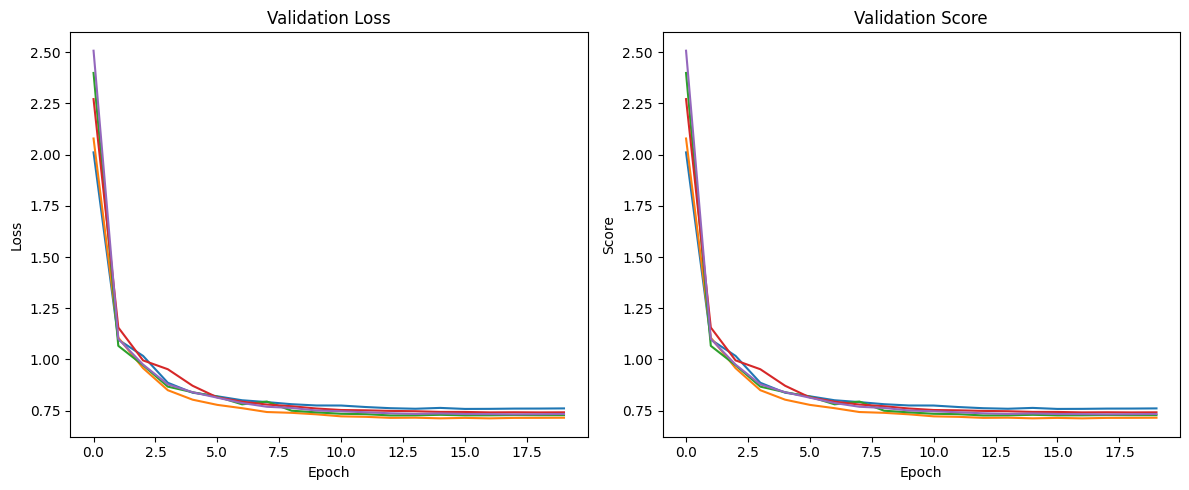

In [21]:
main()

# inference

In [22]:
class EnsembleModel:
    def __init__(self):
        self.models = []

    def __call__(self, x):
        outputs = []
        for model in self.models:
            if CFG.objective_cv == 'binary':
                outputs.append(torch.sigmoid(model(x)).to('cpu').numpy())
            elif CFG.objective_cv == 'multiclass':
                outputs.append(torch.softmax(
                    model(x), axis=1).to('cpu').numpy())
            elif CFG.objective_cv == 'regression':
                outputs.append(model(x).to('cpu').numpy())

        avg_preds = np.mean(outputs, axis=0)
        return avg_preds

    def add_model(self, model):
        self.models.append(model)


def test_fn(valid_loader, model, device):
    preds = []

    for step, (images) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)

        with torch.no_grad():
            y_preds = model(images)

        preds.append(y_preds)

    predictions = np.concatenate(preds)
    return predictions


def inference():
    test = pd.read_csv(CFG.comp_dataset_path +
                       'test_features.csv')

    test['base_path'] = CFG.comp_dataset_path + 'images/' + test['ID'] + '/'

    paths = []
    for base_path in test['base_path'].values:
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix
            paths.append(path)

    print(paths[:5])

    CFG.video_cache = make_video_cache(paths)

    print(test.head(5))

    valid_dataset = CustomDataset(
        test, CFG, transform=get_transforms(data='valid', cfg=CFG))
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    model = EnsembleModel()
    folds = [0] if CFG.use_holdout else list(range(CFG.n_fold))
    for fold in folds:
        _model = CustomModel(CFG, pretrained=False)
        _model.to(device)

        model_path = CFG.model_dir + \
            f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth'
        print('load', model_path)
        state = torch.load(model_path)['model']
        _model.load_state_dict(state)
        _model.eval()

        # _model = tta.ClassificationTTAWrapper(
        #     _model, tta.aliases.five_crop_transform(256, 256))

        model.add_model(_model)

    preds = test_fn(valid_loader, model, device)

    test[CFG.target_col] = preds
    test.to_csv(CFG.submission_dir +
                'submission_oof.csv', index=False)
    test[CFG.target_col].to_csv(
        CFG.submission_dir + f'submission_{CFG.exp_name}.csv', index=False)

In [23]:
inference()

['../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t-1.0.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t-0.5.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_220/image_t-1.0.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_220/image_t-0.5.png']
[255, 227, 199, 170, 142, 114, 85, 57, 29]


0it [00:00, ?it/s]

                                     ID      vEgo      aEgo  steeringAngleDeg  \
0  012baccc145d400c896cb82065a93d42_120  3.374273 -0.019360        -34.008415   
1  012baccc145d400c896cb82065a93d42_220  2.441048 -0.022754        307.860077   
2  012baccc145d400c896cb82065a93d42_320  3.604152 -0.286239         10.774388   
3  012baccc145d400c896cb82065a93d42_420  2.048902 -0.537628         61.045235   
4  01d738e799d260a10f6324f78023b38f_120  2.201528 -1.898600          5.740093   

   steeringTorque  brake  brakePressed  gas  gasPressed gearShifter  \
0            17.0    0.0         False  0.0       False       drive   
1           295.0    0.0          True  0.0       False       drive   
2          -110.0    0.0          True  0.0       False       drive   
3           189.0    0.0          True  0.0       False       drive   
4           -41.0    0.0          True  0.0       False       drive   

   leftBlinker  rightBlinker  \
0        False         False   
1        False        

/workspace/atmacup18/.venv/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(
/tmp/ipykernel_152978/610043316.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don'

load ../proc/baseline/outputs/atmacup_18_cnn_effnetb0/atmacup_18-models/tf_efficientnet_b0_ns_fold1_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_effnetb0/atmacup_18-models/tf_efficientnet_b0_ns_fold2_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_effnetb0/atmacup_18-models/tf_efficientnet_b0_ns_fold3_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_effnetb0/atmacup_18-models/tf_efficientnet_b0_ns_fold4_last.pth


  0%|          | 0/14 [00:00<?, ?it/s]